In [1]:
import glob
import random
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from tqdm import tqdm
import numpy as np

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in simple_preprocess(text, min_len = 4):
        if token not in STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

cat_list = glob.glob ("cuisines/*")
cat_size = len(cat_list)

random.seed(0)
cat_names = []
cat_text = []
# sample_size = min(30, cat_size)
# cat_sample = sorted(random.sample(range(cat_size), sample_size))
cat_sample = range(0, cat_size)

count = 0
for i in cat_sample:
    cat_names.append(cat_list[i].replace("\\", "/").split('/')[-1][:-4].replace("_"," "))
    with open(cat_list[i]) as f:
        cat_text.append(f.read().replace("\n", "").replace("\r",""))

processed_docs = [preprocess(text) for text in tqdm(cat_text)]
dictionary = corpora.Dictionary(processed_docs)
print("Before prunn:%d"%(len(dictionary)))
dictionary.filter_extremes(no_above=0.5)
print("After prunn:%d"%(len(dictionary)))
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

C:\Users\geesi\Anaconda3\envs\dm_cap_mkl_py3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [34:42<00:00, 10.64s/it]


Before prunn:193503
After prunn:43491


In [2]:
import math

def cosine_similarity(a, b):
    b = dict(b)
    norm_a = 0
    norm_b = 0
    denom = 0
    for a_i, a_v in a:
        norm_a += a_v * a_v
        if a_i in b:
            denom += a_v * b[a_i]
    for b_i in b:
        norm_b += b[b_i] * b[b_i]
    
    norm_a = math.sqrt(norm_a)
    norm_b = math.sqrt(norm_b)
#     print(norm_a)
#     print(norm_b)
#     print(denom)
    
    return denom / (norm_a * norm_b)

def top_n(df, n, thresh_hold = 0.1):
    df_count = np.zeros(df.shape)
    df_bak = df
    df_count[df >= thresh_hold] = 1
    _counts = np.sum(df_count, axis=1)
    max_index = []
    for i in range(0, n):
        _index = np.argmax(_counts)
        max_index.append(_index)
        _counts[_index] = -1
    
    return df.iloc[max_index][df.columns[max_index]]

def format_obj(df, groups):
    _nodes = "nodes"
    _links = "links"
    json_obj = {_nodes:[], _links:[]}
    for i in range(0, len(df.columns)):
        json_obj[_nodes].append({"name":df.columns[i], "group":groups[i]})
    
    for i in range(0, df.shape[0] - 1):
        for j in range(i + 1, df.shape[0]):
            json_obj[_links].append({"source":i, "target":j, "value":df.iloc[i][j]})
    
    return json_obj

In [3]:
import numpy as np
import pandas as pd

sim = np.zeros([len(corpus), len(corpus)])

for i in tqdm(range(0, len(corpus) - 1)):
    sim[i][i] = 1
    for j in range(i + 1, len(corpus)):
        sim[i][j] = cosine_similarity(corpus[i], corpus[j])
        sim[j][i] = sim[i][j]
        

sim_df = pd.DataFrame(sim)
sim_df.index = cat_names
sim_df.columns = cat_names
data = top_n(sim_df, 50)

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:29<00:00, 28.00it/s]


In [4]:
import json

with open("display/output.json", "w") as f:
    f.write(json.dumps(format_obj(data, np.ones(data.shape[0]))))

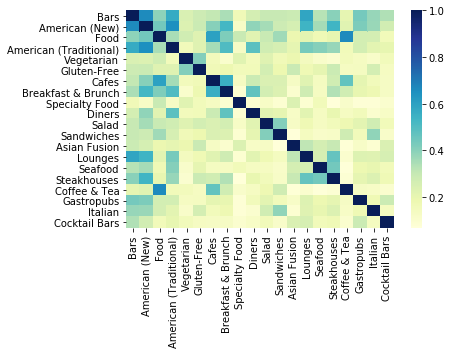

In [5]:
import seaborn as sns; 
import matplotlib.pyplot as plt

sample = 20
ax = sns.heatmap(data.iloc[0:sample][data.columns[0:sample]],cmap="YlGnBu", xticklabels=True, yticklabels=True)
plt.show()

In [14]:
from gensim.models import TfidfModel

model = TfidfModel(corpus)
tfidf_corpus = model[corpus]

tfidf_sim = np.zeros([len(tfidf_corpus), len(tfidf_corpus)])

for i in tqdm(range(0, len(tfidf_corpus) - 1)):
    tfidf_sim[i][i] = 1
    for j in range(i + 1, len(tfidf_corpus)):
        tfidf_sim[i][j] = cosine_similarity(tfidf_corpus[i], tfidf_corpus[j])
        tfidf_sim[j][i] = tfidf_sim[i][j]
        

tfidf_sim_df = pd.DataFrame(tfidf_sim)
tfidf_sim_df.index = cat_names
tfidf_sim_df.columns = cat_names
tfidf_data = top_n(tfidf_sim_df, 50)

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [18:31<00:00,  6.86s/it]


In [15]:
tfidf_data

,Food,American (New),Bars,American (Traditional),Breakfast & Brunch,Asian Fusion,Buffets,Steakhouses,Lounges,Sandwiches,...,Bakeries,Brasseries,Greek,Vegan,Wine Bars,"Beer, Wine & Spirits",Comfort Food,Modern European,Afghan,Arabian
Food,1.000000,0.347387,0.281550,0.266822,0.392105,0.140322,0.187239,0.138220,0.122261,0.305144,...,0.655985,0.110842,0.094266,0.172895,0.128418,0.292587,0.122138,0.087866,0.039963,0.066073
American (New),0.347387,1.000000,0.572032,0.529098,0.428194,0.185782,0.233694,0.447010,0.379933,0.229364,...,0.117855,0.158368,0.083905,0.074893,0.257527,0.164348,0.159594,0.224505,0.024045,0.043714
Bars,0.281550,0.572032,1.000000,0.491179,0.311028,0.223969,0.160505,0.315266,0.523483,0.230765,...,0.076585,0.132228,0.076400,0.072901,0.508953,0.161242,0.144083,0.163159,0.029804,0.024013
American (Traditional),0.266822,0.529098,0.491179,1.000000,0.428970,0.144801,0.182379,0.298119,0.334701,0.201389,...,0.084738,0.106240,0.049049,0.052287,0.123083,0.140805,0.146031,0.115976,0.010871,0.014029
Breakfast & Brunch,0.392105,0.428194,0.311028,0.428970,1.000000,0.075672,0.200953,0.269879,0.227942,0.214098,...,0.248306,0.199479,0.030436,0.052368,0.197772,0.079695,0.147755,0.109133,0.006545,0.009646
Asian Fusion,0.140322,0.185782,0.223969,0.144801,0.075672,1.000000,0.220854,0.209184,0.183367,0.049680,...,0.028987,0.033666,0.019605,0.059310,0.036749,0.033327,0.067690,0.054945,0.019084,0.004944
Buffets,0.187239,0.233694,0.160505,0.182379,0.200953,0.220854,1.000000,0.310642,0.137545,0.067651,...,0.130019,0.038140,0.037157,0.096462,0.043263,0.057744,0.064855,0.047043,0.121906,0.023212
Steakhouses,0.138220,0.447010,0.315266,0.298119,0.269879,0.209184,0.310642,1.000000,0.292288,0.092495,...,0.047335,0.115076,0.024280,0.028223,0.176071,0.053250,0.081680,0.130199,0.004646,0.005414
Lounges,0.122261,0.379933,0.523483,0.334701,0.227942,0.183367,0.137545,0.292288,1.000000,0.089606,...,0.040628,0.069520,0.048830,0.028334,0.103394,0.077516,0.075997,0.110496,0.008733,0.018823
Sandwiches,0.305144,0.229364,0.230765,0.201389,0.214098,0.049680,0.067651,0.092495,0.089606,1.000000,...,0.147805,0.076006,0.048634,0.058151,0.134007,0.077268,0.110308,0.066977,0.011893,0.015658


In [16]:
import json

with open("display/tfidf_output.json", "w") as f:
    f.write(json.dumps(format_obj(tfidf_data, np.ones(tfidf_data.shape[0]))))